### Installation des dépendances

In [1]:
%pip install numpy
%pip install opencv-python
%pip install -U matplotlib
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math
import os
import time

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\loicn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\loicn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\loicn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Define Constants
STEP_TO_NEXT_FRAME = 4 
""" in each video, we will read 1 frame every 24/STEP_TO_INDEX frames"""
DEBUG = False # if True, print debug information
NUMBER_OF_VIDEO = 100 # number of videos to index
MAX_FRAME_INDEXATION_TIME = 3 # in seconds
MAX_SEARCH_TIME = 0.1 # in seconds
VIDEOS_SIZE_ON_DISK = 444039168  # in octets
MAX_FRAME_NUMBER = 37895 # maximum number of frames in a video
N = int(MAX_FRAME_NUMBER/STEP_TO_NEXT_FRAME) # index Length
D = 128 # index Depth

In [3]:
#Define all global variables
imageList = []
videoList = []
frameIndexationTime = [] # Time must be in seconds
imageSearchTime = [] # Time must be in seconds
imageCompressionRateList = []
videoCompressionRateList = []
indexationTable = [] # Table of indexation
Descriptor_list = np.empty((N, D * 3), dtype=np.float32) # Descriptor of the image

### Lecture des fichiers

In [4]:
imagePath = "/data/jpeg/"
videoPath = "/data/mp4/"
currDirectory = os.getcwd()
imageList = os.listdir(currDirectory + imagePath)
videoList = os.listdir(currDirectory + videoPath)
# for file in imageList:
#     filePath = currDirectory + dataPath + file
#     img = cv.imread(filePath, cv.IMREAD_COLOR)

In [5]:
def getVideoParameter(videoPath:str):
    """return the frame rate and the number of frames of the video."""
    cap = cv.VideoCapture(videoPath)
    fps = cap.get(cv.CAP_PROP_FPS)
    frame_count = cap.get(cv.CAP_PROP_FRAME_COUNT)
    return fps, frame_count
    

In [6]:
def displayRGBHistogram(histogram_r, histogram_g, histogram_b):
    plt.plot(histogram_b, color='blue', label='Canal bleu')
    plt.plot(histogram_g, color='green', label='Canal vert')
    plt.plot(histogram_r, color='red', label='Canal rouge')
    plt.xlabel('Intensité des pixels')
    plt.ylabel('Nombre de pixels')
    plt.title('Histogramme de l\'image')
    plt.legend()
    plt.show()

In [7]:

def convertImageToVector(imagePath, needToRead:bool = True):
    """return the histogram of the image."""
    if needToRead:
        image = cv.imread(imagePath)
    else:
        image = imagePath

    #Separate the color channels
    canal_b = image[:, :, 0]
    canal_g = image[:, :, 1]
    canal_r = image[:, :, 2]

    # Calculate histograms for each channel
    # D means we will have 256/D values in the histogram
    histogram_b = cv.calcHist([canal_b], [0], None, [D], [0, 256])
    histogram_g = cv.calcHist([canal_g], [0], None, [D], [0, 256])
    histogram_r = cv.calcHist([canal_r], [0], None, [D], [0, 256])
    
    vector_r = histogram_r.flatten()
    vector_g = histogram_g.flatten()
    vector_b = histogram_b.flatten()
    
    histogramme_complet = np.concatenate((vector_r, vector_g, vector_b))
    
    if DEBUG:
        displayRGBHistogram(histogram_r, histogram_g, histogram_b)

    return histogramme_complet

In [8]:
def createIndexTable():
    """Index a video by creating a list of frames and their corresponding index. and update the indexationTable variable."""
    for video in videoList:
        path = currDirectory + videoPath + video
        fps, frame_count= getVideoParameter(path)
        cap = cv.VideoCapture(path)
        startIndex = len(indexationTable)
        stopIndex = startIndex - 1 + math.floor(frame_count/STEP_TO_NEXT_FRAME)
        for i in range(startIndex, stopIndex):
            frameNumber = STEP_TO_NEXT_FRAME*(i-startIndex)
            indexationTable.append((frameNumber, video, (frameNumber/fps)))
            currImage = cap.set(cv.CAP_PROP_POS_FRAMES, frameNumber)
            ret, currImage = cap.read()
            Descriptor_list[i] = convertImageToVector(currImage, False)
        
createIndexTable()

In [9]:
def CalculateCompressionRate():
    print(len(indexationTable))
    print(Descriptor_list.shape)
    rate = 1- (3*D*N*4)/VIDEOS_SIZE_ON_DISK #*4 because we use float32 and 3 because we have 3 channels RGB
    print(rate)
    
CalculateCompressionRate()

9338
(9473, 384)
0.9672314312596856


In [13]:
def plotImage(image, type):
    figure = plt.figure(figsize = (10,10))
    imageout = np.clip(image,0,255)
    imageout= imageout.astype(type)
    plt.imshow(imageout, cmap='gray')
    plt.show()

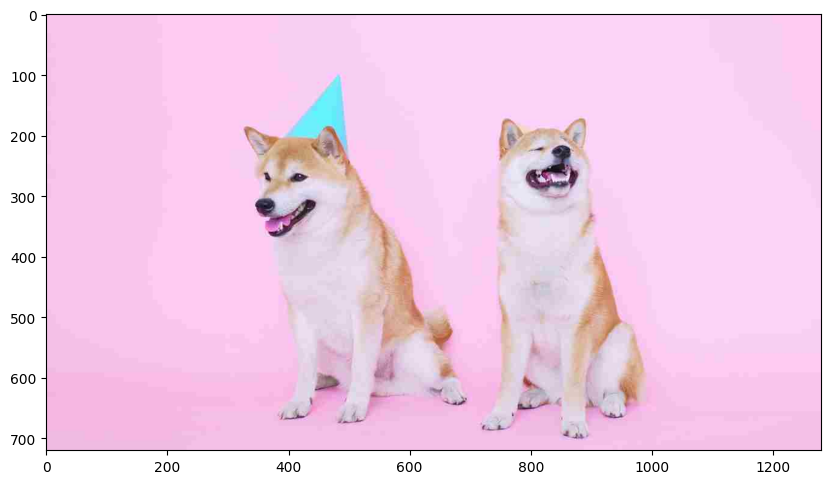

The best match is the frame number  (0, 'v001.mp4', 0.0)  with a distance of  637783.25 index est:  9


In [22]:
def searchImage():
    bestDistance = 0
    for image in imageList:
        path = currDirectory + imagePath + image
        plotImage(cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB), 'uint8')
        imageVector = convertImageToVector(path)
        for i in range(len(indexationTable)):
            # calculer la norme de la différence entre l'image et la liste de descripteurs
            dist = np.linalg.norm(imageVector - Descriptor_list[i])
            if i == 0:
                bestDistance = dist
                bestIndex = i
            if dist < bestDistance:
                bestDistance = dist
                bestIndex = i
        print("The best match is the frame number ", indexationTable[bestIndex], " with a distance of ", bestDistance,"index est: ",i)
        break
    
searchImage()

In [11]:
def writeSearchResults():
    

SyntaxError: incomplete input (3781726569.py, line 2)

In [ ]:
def verifyFrameIndexationTime():
    """Function to verify if the indexation time of each frame is less than the max time allowed for indexation per frame."""
    videoToReindex = []
    totalIndexationTime = 0
    for i in range(0, len(frameIndexationTime)):
        totalIndexationTime += frameIndexationTime[i]
        if(frameIndexationTime[i] > MAX_FRAME_INDEXATION_TIME):
            videoToReindex.append(i)
    if len(videoToReindex) != 0:
        print("Les vidéos suivantes doivent être réindexées car elles prennent plus de temps que le temps maximal d'indexation par frame: " + str(MAX_FRAME_INDEXATION_TIME) + " secondes")
        for i in range(0, len(videoToReindex)):
            print(videoList[videoToReindex[i]])
    print("Toutes les vidéos ont été correctement indexées\nLe temps d'indexation total est: " + str(totalIndexationTime/60.0) + " minutes")


In [ ]:
def verifyImageSearchTime():
    """Function to verify if the search time for each image is less than the max time allowed for search per image."""
    imageToResearch = []
    totalSearchTime = 0
    for i in range(0, len(imageSearchTime)):
        totalSearchTime += imageSearchTime[i]
        if(imageSearchTime[i] > MAX_SEARCH_TIME):
            imageToResearch.append(i)
    if len(imageToResearch) != 0:
        print("La recherche doit être révisée pour les images suivantes car elles prennent plus de temps que le temps maximal de recherche par image: " + str(MAX_SEARCH_TIME) + " secondes")
        for i in range(0, len(imageToResearch)):
            print(imageList[imageToResearch[i]])
    print("Le temps de recherche total est: " + str(totalSearchTime) + " secondes")

In [ ]:
# Cell for test purposes
calculateTotalFrame()